### Tarea 3 Deep Learning

#### Integrantes:
* Elisa Parga
* Nicolás Fierro

# Clasificación de Células Sanguíneas

En el proceso de diagnóstico de enfermedades, el estudio de la cantidad de células sanguíneas juega un papel importante para determinar factores que explican una enfermedad. En esta tarea, la idea es implementar el modelo de deep-learning más efectivo posible para clasificar células sanguíneas. Las clases de células sanguíneas son: [Eosinophil, Lymphocyte, Monocyte, Neutrophil]


In [1]:
#Instalamos el paquete gdown para poder descargar el dataset desde el gdrive
!pip install gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
#Descargamos el dataset
import gdown
output = 'blood.zip'
gdown.download(id='1CUQjT45tJmqNv_p2HcDkr4Z-IDQEbRg3', output=output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1CUQjT45tJmqNv_p2HcDkr4Z-IDQEbRg3
To: /content/blood.zip
100%|██████████| 105M/105M [00:00<00:00, 184MB/s] 


'blood.zip'

In [3]:
# Descomprimimos el dataset
!unzip blood.zip

Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: images/TRAIN/MONOCYTE/_0_4446.jpeg  
  inflating: images/TRAIN/MONOCYTE/_0_4528.jpeg  
  inflating: images/TRAIN/MONOCYTE/_0_453.jpeg  
  inflating: images/TRAIN/MONOCYTE/_0_4560.jpeg  
  inflating: images/TRAIN/MONOCYTE/_0_4563.jpeg  
  inflating: images/TRAIN/MONOCYTE/_0_4650.jpeg  
  inflating: images/TRAIN/MONOCYTE/_0_4667.jpeg  
  inflating: images/TRAIN/MONOCYTE/_0_4715.jpeg  
  inflating: images/TRAIN/MONOCYTE/_0_4745.jpeg  
  inflating: images/TRAIN/MONOCYTE/_0_4762.jpeg  
  inflating: images/TRAIN/MONOCYTE/_0_4778.jpeg  
  inflating: images/TRAIN/MONOCYTE/_0_4791.jpeg  
  inflating: images/TRAIN/MONOCYTE/_0_4862.jpeg  
  inflating: images/TRAIN/MONOCYTE/_0_4872.jpeg  
  inflating: images/TRAIN/MONOCYTE/_0_4881.jpeg  
  inflating: images/TRAIN/MONOCYTE/_0_4884.jpeg  
  inflating: images/TRAIN/MONOCYTE/_0_4925.jpeg  
  inflating: images/TRAIN/MONOCYTE/_0_494.jpeg  
  inflating: images/TRAIN/MONOCYTE/_0_502

Implementa la mejor red neuronal posible. Tú decides si usas una red creada por ti mismo o si empleas transfer-learning. Entrena la red con los datos en la carpeta "TRAIN" y usa los datos en "VAL" como validación.

Para medir el performance final, realiza las inferencias sobre los datos del conjunto "TEST" y computa el accuracy sobre el conjunto de test. El accuracy es la proporción de imágenes para las cuales la predicción es correcta. IMPORTANTE: el accuracy de test se calcula una sola vez cuando hayas finalizado todos tus experimentos. Para tomar decisiones sobre el modelo y sus hiperparámetros solo puedes usar el conjunto de entrenamiento y validación.

Detalla todos los experimentos que hiciste y cómo llegaste a la mejor red neuronal reportada. Discute los resultados, comparando los distintos experimentos que tomaste en cuenta y responde a la pregunta: Porqué tu modelo final fue el mejor de todo lo que probaste?

IMPORTANTE: Evita el overfitting a toda costa. Un modelo con overfitting es aquel que durante el entrenamiento las curvas de loss/accuracy para datos de entrenamiento y validación se separan considerablemente. 

Éxitos!

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, models, transforms
import time
import os
import copy
from torchvision.io import read_image
from PIL import Image

En primero lugar, debemos construir nuestro pytorch dataset. Para esto creamos la clase BloodDataset que herda del módulo torch.utils.data.Dataset.

Esta clase nos crea un dataset preparado para ser procesado por pytorch según el split que se indique como parámetro. En la inicialización de nuestra clase, se leen los nombres de las imagenes correspondientes al split indicado según sus labels y tanto el nombre del archivo como el nombre de su label se agregan a listas de forma ordenada.

In [5]:
class BloodDataset(torch.utils.data.Dataset):
  def __init__(self, root, split, transform=None):
    self.root = root
    self.split = split
    self.transform = transform
    self.classBlood = dict()

    self.classBlood["EOSINOPHIL"] = 0
    self.classBlood["LYMPHOCYTE"] = 1
    self.classBlood["MONOCYTE"] = 2
    self.classBlood["NEUTROPHIL"] = 3

    self.classes = ["EOSINOPHIL", "LYMPHOCYTE", "MONOCYTE", "NEUTROPHIL"]

    self.images = []
    self.labels = []

    dataset_path = os.path.join(self.root, self.split)
    for label in self.classes:
      label_path = os.path.join(dataset_path, label)
      for filename in sorted(os.listdir(label_path)):
        self.images.append(filename)
        self.labels.append(label)

  def __len__(self):
    return len(self.images)

  def __getitem__(self, idx):
    img_path = os.path.join(self.root, self.split, self.labels[idx], self.images[idx])
    image = Image.open(img_path)
    label = self.classBlood[self.labels[idx]]
    image = image.convert('RGB')
    if self.transform:
      image = self.transform(image)
    return image, label

Para obtener un buen modelo debemos crear una red neuronal capaz de, en primer lugar, generar un vector de características representativo de la imagen (feature extraction)  y en segundo lugar, identificar correctamente a qué clase corresponde este vector (classification head). Mirando el tamaño del dataset podemos observar que no es muy grande como para poder entrenar una red capaz generar un buen vector de características. Es por esto que se implementa el método de Transfer Learning. 

Se usarán las capas de feature extraction de diferentes redes pre-entrenadas en un dataset de imágenes a color, ImageNet. Luego se creará una red de clasifique de manera correcta los vectores generados. Es esta parte la más experimental, con la que se probarán diferentes soluciones.

En primer lugar, para poder hacer uso de las redes pre-entrenadas con ImageNet, debemos generar un conjunto de datos acorde a las estadísticas de este dataset. Para esto asumimos que nuestras imágenes tienen la misma distribución de pixeles que las imágenes de ImageNet. Hacemos las transformaciones correspondientes a este y así, podemos visualizar entonces cuántas imágenes contiene cada split de datos (TRAIN, TEST y VAL):

In [6]:
train_dataset = BloodDataset(root='images/', split='TRAIN', transform=transforms.Compose([
                                                            transforms.RandomResizedCrop(224), 
                                                            transforms.ToTensor(), 
                                                            transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                                                                std=[0.229, 0.224, 0.225])]))
print(len(train_dataset))

9957


In [7]:
test_dataset = BloodDataset(root='images/', split='TEST', transform=transforms.Compose([
                                                            transforms.Resize(256),
                                                            transforms.CenterCrop(224), 
                                                            transforms.ToTensor(), 
                                                            transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                                                                std=[0.229, 0.224, 0.225])]))
print(len(test_dataset))

2487


In [8]:
validation_dataset = BloodDataset(root='images/', split='VAL', transform=transforms.Compose([
                                                            transforms.Resize(256),
                                                            transforms.CenterCrop(224), 
                                                            transforms.ToTensor(), 
                                                            transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                                                                std=[0.229, 0.224, 0.225])]))
print(len(validation_dataset))

71


Creamos una función que nos permite visualizar una imagen:

In [9]:
def imshow(inp, title = None):
  plt.figure(figsize=(10,20))
  inp = inp.numpy().transpose((1, 2, 0))
  mean = np.array([0.5])
  std = np.array([0.5])
  inp = std * inp + mean
  inp = np.clip(inp, 0, 1)
  plt.imshow(inp)
  
  if title is not None:
    plt.title(title)
  plt.pause(0.001)

Visualizamos cómo son las imágenes de entrada a nuestra red (con las transformaciones acordes a las estadísticas de ImageNet). Hacemos el plot de una imagen por clase:

In [10]:
classes = train_dataset.classBlood

def get_label_from_value(classDict, value):
  for k in classDict:
    if classDict[k] == value:
      return k

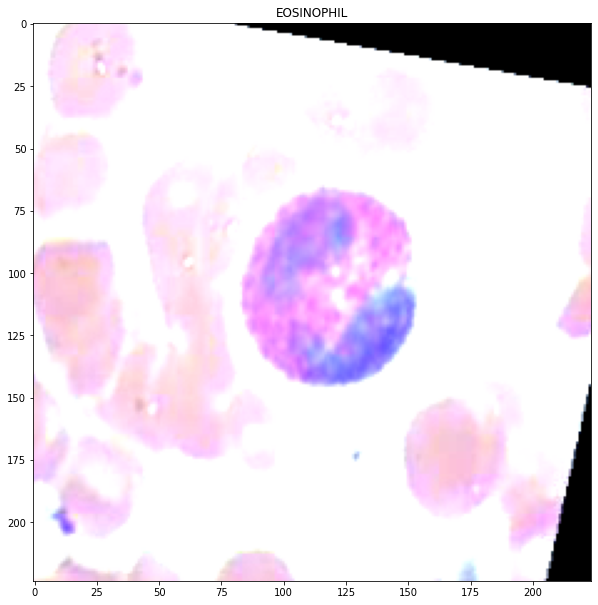

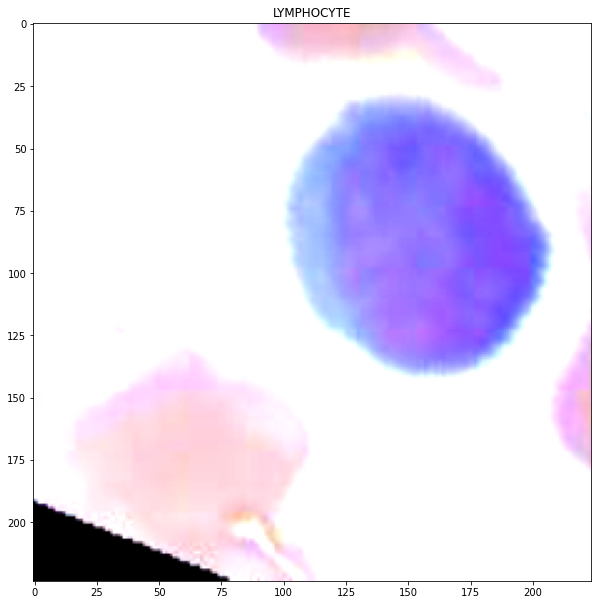

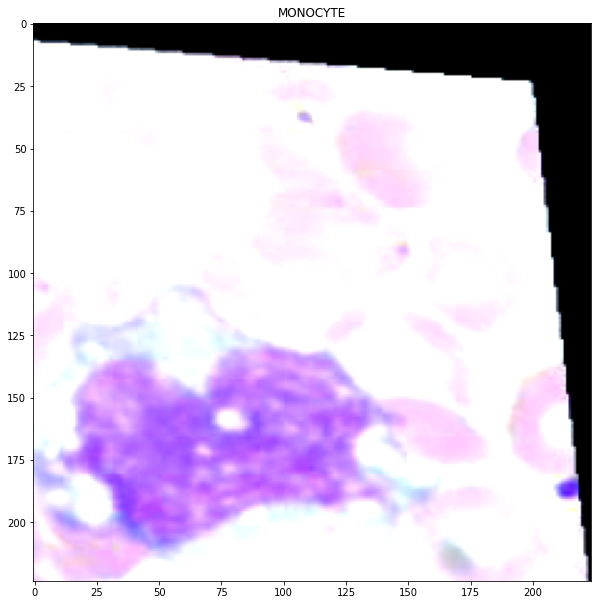

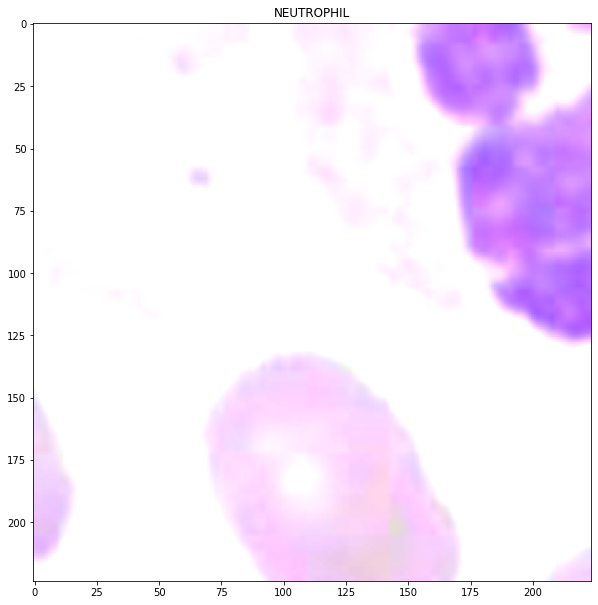

In [11]:
i=0
for data in train_dataset:
  if data[1] == i:
    label = get_label_from_value(classes, i)
    imshow(data[0], label)
    i += 1 

Definimos los hiperparámetros y escribimos los loaders para dejar los datos listos para ser entrenados:

In [12]:
# Hyper-parameters 
input_size = 784
num_classes = 4
num_epochs = 5
batch_size_train = 100
batch_size_test = 300
batch_size_val = 20
momentum = 0.9
log_interval = 100
learning_rate=0.001

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size_train, shuffle=True)
val_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=batch_size_val, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size_test, shuffle=True)

class_names = train_dataset.classes
device = ('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [19]:
train_loader

Creamos nuestra función de entrenamiento:

In [13]:
torch.manual_seed(1234)
torch.cuda.manual_seed(1234)

# los dos ultimos parametros son usados para entrenar con loaders que tienen transformaciones distintas
def train_model(model, criterio, optimizer, scheduler, num_epochs = 25, train_loader=train_loader, validation_loader=val_loader, plot=True):
  since = time.time()
  
  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0
  
  training_loss = []
  training_accuracy = []

  validation_loss = []
  validation_accuracy = []
  for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs-1))
    print('-' * 10)
    
    #Train model
    scheduler.step()
    model.train()
    
    running_loss = 0.0
    running_corrects = 0.0
    
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterio(outputs, labels)
          
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
    
    epoch_loss = running_loss /len(train_dataset)
    epoch_acc = running_corrects.double() / len(train_dataset)

    training_loss.append(epoch_loss)
    training_accuracy.append(epoch_acc.cpu())
      
    print('Train Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))
    
    #Validation 
    model.eval()
    running_loss = 0.0
    running_corrects = 0.0
    
    for inputs, labels in validation_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)
        
      with torch.set_grad_enabled(False):
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterio(outputs, labels)
          
      running_loss += loss.item() * inputs.size(0)
      running_corrects += torch.sum(preds == labels.data)
     
    epoch_loss = running_loss /len(validation_dataset)
    epoch_acc = running_corrects.double() / len(validation_dataset)

    validation_loss.append(epoch_loss)
    validation_accuracy.append(epoch_acc.cpu())
      
    print('Val Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))
    
    if epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model_wts = copy.deepcopy(model.state_dict())
        
  time_elapsed = time.time() - since
  print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed//60, time_elapsed % 60))
  print('Best val accucary: {:.4f}'.format(best_acc))

  if plot:
    plt.figure()
    plt.plot(training_loss, color='b', label='Train Loss')
    plt.plot(validation_loss, color='r', label='Validation Loss')
    plt.title("Training and Validation Loss")
    plt.legend()
    plt.show()

    plt.figure()
    plt.plot(training_accuracy, color='b', label='Train Accuracy')
    plt.plot(validation_accuracy, color='r', label='Validation Accuracy')
    plt.title("Training and Validation Accuracy")
    plt.legend()
    plt.show()

  model.load_state_dict(best_model_wts)
  return model

Cargamos la red resnet18 que fue entrenada con el dataset ImageNet. Observamos cómo está compuesta para saber cómo debemos construír nuestra cabeza de clasificación:

In [14]:
resnet18_model = models.resnet18(pretrained=True)
print(resnet18_model)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Obtenemos un resumen de la red:

In [15]:
import torchsummary as ts

ts.summary(resnet18_model.to(device), input_size=(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

Observamos que esta red tiene más de 11 millones de parámetros, es por esto que es importante hacer uso de Transfer Learning con Fine Tunning, de lo contrario, con el tamaño de nuestro dataset no seremos capaces de hacer una optimización de parámetros con inicialiazación aleatoria, debemos comenzar con el pre-entrenamiento hecho sobre ImageNet.

En la arquitectura de la red, remarcamos que nos interesan las capas convolucionales que generan el vector de características. Estas capas se encuentran antes de (fc), que es donde comienzan los perceptrones lineales. A partir de esta capa, debemos crear nuestra propia arquitectura. 

Se modifica entonces la cabeza de clasificación por una sola capa lineal que determina a cuál de las 4 clases pertenece el vector de características ingresado.

Hacemos un "fine tuning" de la red para que se ajuste de la mejor manera posible a estos nuevos datos:

In [16]:
#Fine tuning
num_ft = resnet18_model.fc.in_features
resnet18_model.fc = nn.Linear(num_ft, 4) # solo cambiamos el número de neuronas de salidas, pues tenemos 4 clases

Decidimos que el criterio para la optimización será la Cross Entropy Loss, usamos el método de gradiente estocástico para la optimización con momento de 0.9 y programamos un scheduler que reduce en 0.1 el tamaño de la learning rate cada 7 épocas. Es importante hacer uso de este scheduler porque cuando hacemos transfer learning partimos de un punto óptimo dado por el modelo pre-entrenado a utilizar, por lo que para encontrar mínimos más óptimos, debemos reducir este learning rate y "avanzar" progresivamente.

In [17]:
model_ft_v1 = resnet18_model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_ft_v1.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

model_ft_v1 = train_model(model_ft_v1, criterion, optimizer, exp_lr_scheduler, num_epochs=50)

Epoch 0/49
----------


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Train Loss: 0.9944 Acc: 0.5678
Val Loss: 0.5884 Acc: 0.8028
Epoch 1/49
----------


KeyboardInterrupt: ignored

Luego de 50 iteraciones, observamos que con solo una capa final de clasificación, la red no loga seguir aprendiendo. Se "estanca" a partir de la iteración número 10. Esto se puede deber a que la parte de selección de características de ResNet18 no logra capturar información relevante generando un vector de características no muy representativo. Otra posibilidad es que el modelo que clasifica dicho vector no lo logra hacer de forma correcta. 

Es por esto que se entrenan nuevas redes manteniendo las capas convolucionales pertenecientes a ResNet18 y modificando las arquitecturas de la cabeza de clasificación con diferentes capas de perceptrones.

El siguiente modelo cambia la última capa de clasificación por una red de perceptrones lineales que disminuye el número de neuronas por capa gradualmente hasta llegar a una salida de 4 valores. La arquitectura toma la la siguiente forma (en número de neuronas por capa):
* Vector de características - 425 - 240 - 75 - 4.

In [ ]:
# Vemos si implementando más capas en la clasificación MLP aumenta la accuracy
resnet18_model = models.resnet18(pretrained=True)
num_ft = resnet18_model.fc.in_features
resnet18_model.fc = nn.Sequential(
    nn.Linear(num_ft, 425),
    nn.ReLU(),
    nn.Linear(425, 240),
    nn.ReLU(),
    nn.Linear(240, 75),
    nn.ReLU(),
    nn.Linear(75, 4)
)

model_ft_v2 = resnet18_model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_ft_v2.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

model_ft_v2 = train_model(model_ft_v2, criterion, optimizer, exp_lr_scheduler, num_epochs=30)


Observamos que el modelo no mejora la accuracy ni logra aprender de mejor manera que la primera red implementada con una sola capa de clasificación. Es probable entonces, que la red pre-entrenada que se utilizó (ResNet18) no esté logrando capturar las características de la imagen que la permiten clasificar de forma correcta.

Hacemos un último experimento con dos capas de perceptrones lineales de la siguiente forma (en número de neuronas):
* Vector de características - 256 - 4.

In [ ]:
# Vemos si implementando más capas en la clasificación MLP aumenta la accuracy
resnet_model = models.resnet18(pretrained=True)
num_ft = resnet_model.fc.in_features
resnet_model.fc = nn.Sequential(
    nn.Linear(num_ft, 256),
    nn.ReLU(),
    nn.Linear(256, 4)
)

model_ft_v3 = resnet_model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_ft_v3.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

model_ft_v3 = train_model(model_ft_v3, criterion, optimizer, exp_lr_scheduler, num_epochs=30)

Nuevamente se observa que la red no logra clasificar de forma precisa por lo que en caso de usar ResNet18, el mejor modelo es con una sola capa lineal al final.

A pesar de los resultados obtenidos en un primer momento, observamos que los datos pueden ser aprendidos de mejor manera, pues en el primer experimento la red se "estancada" a partir de la época 10 sin mostrar señales de overfitting. Esto nos hace pensar que podríamos usar un modelo más potente y con mayor capacidad de obtener información a partir de una imagen. Se procede entonces a entrenar una red con un mayor número de capas convolucionales y parámetros, en este caso, se decide usar ResNet50 que tiene más del doble de parámetros que ResNet18:

In [ ]:
resnet50_model = models.resnet50(pretrained=True)
print(resnet50_model)

In [ ]:
import torchsummary as ts

ts.summary(resnet50_model.to(device), input_size=(3,224,224))

Usamos solo una capa final de clasificación, pues en experimentos anteriores fue lo que nos dio mejores resultados.

In [ ]:
# para "limpiar" la memoria
torch.cuda.empty_cache()
import gc
gc.collect()

num_ft = resnet50_model.fc.in_features
resnet50_model.fc = nn.Linear(num_ft, 4)

resnet50_model = resnet50_model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(resnet50_model.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

resnet50_v1 = train_model(resnet50_model, criterion, optimizer, exp_lr_scheduler, num_epochs=15)

In [ ]:
# guardamos el modelo
torch.save(resnet50_v1.state_dict(), 'resnet50_v1.pth')

Notamos que rápidamente la red muestra mejores resultados que ResNet18 pero comenzamos a observar una gran tendencia al overfit de datos, pues podemos ver cómo la train accuracy aumenta mientras la validation accuracy no, observamos la gran diferencia que existe entre ambas al final del entrenamiento. Esto es un claro ejemplo de que la red más que aprender de los ejemplares que entran, está tendiendo a memorizar los datos.

Debido al estado del arte estudiado en clases, es que se decide probrar con la red resnext50_32x4d.

In [ ]:
resnext50_32x4d_model = models.resnext50_32x4d(pretrained=True)
print(resnext50_32x4d_model)

In [ ]:
import torchsummary as ts
ts.summary(resnext50_32x4d_model.to(device), input_size=(3,224,224))

In [ ]:
# para "limpiar" la memoria
torch.cuda.empty_cache()
import gc
gc.collect()

num_ft = resnext50_32x4d_model.fc.in_features
resnext50_32x4d_model.fc = nn.Linear(num_ft, 4)

resnext50_32x4d_model = resnext50_32x4d_model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(resnext50_32x4d_model.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

resnext50_32x4d_v1 = train_model(resnext50_32x4d_model, criterion, optimizer, exp_lr_scheduler, num_epochs=15)

In [ ]:
# guardamos el modelo
torch.save(resnext50_32x4d_v1.state_dict(), 'resnet50_34x4d_v1.pth')

Se observa una tendiencia al overfitting, ya que el loss en entrenamiento disminuye, pero esto no se replica con el de validación. Para evitar esto es necesario probar técnicas que a priori prevén la "memorización" de datos

Hacemos un otro experimento para evaluar el comportamiento de un modelo diferente, en este caso, se decide probar la red Inception V3. En primer lugar, cargamos el modelo:

In [ ]:
model_ft = models.inception_v3(pretrained=True)
model_ft.aux_logits=False
print(model_ft)

Esta red, a pesar de haber sido entrenada bajo el mismo dataset de ImageNet, requiere otro tipo de recorte en las transformaciones, es por esto que creamos nuevos datasets y dataloaders que se adecúen correctamente al tamaño de la entrada de Inception V3.

In [ ]:
train_dataset_inception = BloodDataset(root='images/', split='TRAIN', transform=transforms.Compose([
                                                            transforms.RandomResizedCrop(299),
                                                            transforms.RandomHorizontalFlip(), # para data augmentation
                                                            transforms.ToTensor(),
                                                            transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                                                                std=[0.229, 0.224, 0.225])]))
val_dataset_inception = BloodDataset(root='images/', split='VAL', transform=transforms.Compose([
                                                            transforms.Resize((299, 299)),
                                                            transforms.ToTensor(), # ToTensor : [0, 255] -> [0, 1]
                                                            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                                                std=[0.229, 0.224, 0.225])]))

train_loader_inception = torch.utils.data.DataLoader(train_dataset_inception, batch_size=batch_size_train, shuffle=True)
val_loader_inception = torch.utils.data.DataLoader(val_dataset_inception, batch_size=batch_size_val, shuffle=True)

In [ ]:
num_ft = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ft, 4)

model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

inception_v3_v1 = train_model(model_ft, criterion, optimizer, exp_lr_scheduler, num_epochs=15, train_loader=train_loader_inception, validation_loader=val_loader_inception)

In [ ]:
# guardamos el modelo
torch.save(inception_v3_v1.state_dict(), 'inception_v3_v1.pth')

Notamos que con este modelo se obtienen mejores resultados que con ResNet18. Al compararlo con los resultados de ResNet50 mostrados previamente observamos que Inception V3 tiene mucho menos overfitting que ResNet50, pero alcanza una train y validation accuracy menor. Además, Inception V3 tarda considerablemente más tiempo en entrenarse que las otras redes.

A continuación, con el objetivo de encontrar un mejor modelo, se utilizarán técnicas para evitar el overfitting de datos. Se hará uso de data augmentation para re-entrenar los modelos de ResNet50 e InceptionV3 que fueron los que entregaron mejores resultados en train accuracy y una notoria diferencia con la validation accuracy que se espera reducir (aumentando la validation accuracy).

### **Data Augmentation**

Para que nuestros modeles logren generalizar de mejor manera y eviten el overfitting de datos, podemos agregar transformaciones aleatorias al momento de ingresar los datos al entrenamiento. De esta forma, en cada época las imágenes entrarán modificadas aleatóriamente con las siguientes posibles transformaciones: horizontal flip, vertical flip y rotación aleatoria. Para las dos primeras transformaciones se puede agregar como parámetro una probabilidad de que esta se aplique que se decide dejar en 0.5 (valor por default). Para la rotación, se puede definir como parámetro el rango de ángulos en los que se rotará nuestra imagen, para el caso se deja en -60, +60 grados.

Al entrar las imágenes en cada época con transformaciones diferentes, es como si hubieran más imágenes para entrenar la red, pues el mismo dato en dos iteraciones diferentes, se presenta de dos formas distintas. Por esta misma razón, se aumentan el número de épocas para entrenar el modelo, pues éste va a tardar más en aprender y generalizar. Pasamos de 15 épocas a 30 épocas y dejamos igual nuestro optimizador y scheduler.

### **ResNet50**

In [ ]:
augmented_train_dataset = train_dataset = BloodDataset(root='images/', split='TRAIN', transform=transforms.Compose([
                                                            transforms.RandomVerticalFlip(),
                                                            transforms.RandomHorizontalFlip(),
                                                            transforms.RandomRotation(60),
                                                            transforms.RandomResizedCrop(224), 
                                                            transforms.ToTensor(), 
                                                            transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                                                                std=[0.229, 0.224, 0.225])]))

augmented_train_loader = torch.utils.data.DataLoader(augmented_train_dataset, batch_size=batch_size_train, shuffle=True)

In [ ]:
# para "limpiar" la memoria
torch.cuda.empty_cache()
import gc
gc.collect()

num_ft = resnet50_model.fc.in_features
resnet50_model.fc = nn.Linear(num_ft, 4)

resnet50_model_aug = resnet50_model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer_resnet50_aug = torch.optim.SGD(resnet50_model_aug.parameters(), lr=0.001, momentum=0.9)
scheduler_resnet50_aug = torch.optim.lr_scheduler.StepLR(optimizer_resnet50_aug, step_size=7, gamma=0.1)

resnet50_aug_v1 = train_model(resnet50_model_aug, criterion, optimizer_resnet50_aug, scheduler_resnet50_aug, num_epochs=30, train_loader=augmented_train_loader)

In [ ]:
# guardamos el modelo
torch.save(resnet50_aug_v1.state_dict(), 'resnet50_aug.pth')

### **Resnext50_32x4d**

In [ ]:
# para "limpiar" la memoria
torch.cuda.empty_cache()
import gc
gc.collect()

num_ft = resnext50_32x4d_model.fc.in_features
resnext50_32x4d_model.fc = nn.Linear(num_ft, 4)

resnext50_32x4d_model_aug = resnext50_32x4d_model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer_resnext50_32x4d_aug = torch.optim.SGD(resnext50_32x4d_model_aug.parameters(), lr=0.001, momentum=0.9)
scheduler_resnext50_32x4d_aug = torch.optim.lr_scheduler.StepLR(optimizer_resnext50_32x4d_aug, step_size=7, gamma=0.1)

resnext50_32x4d_aug_v1 = train_model(resnext50_32x4d_model_aug, criterion, optimizer_resnext50_32x4d_aug, scheduler_resnext50_32x4d_aug, num_epochs=30, train_loader=augmented_train_loader)

In [ ]:
# guardamos el modelo
torch.save(resnext50_32x4d_aug_v1.state_dict(), 'resnet50_32x4d_aug.pth')

### **Inception V3**

In [ ]:
augmented_train_dataset_inception = BloodDataset(root='images/', split='TRAIN', transform=transforms.Compose([
                                                            transforms.RandomVerticalFlip(),
                                                            transforms.RandomHorizontalFlip(),
                                                            transforms.RandomRotation(60),
                                                            transforms.RandomResizedCrop(299),
                                                            transforms.ToTensor(),
                                                            transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                                                                std=[0.229, 0.224, 0.225])]))
val_dataset_inception = BloodDataset(root='images/', split='VAL', transform=transforms.Compose([
                                                            transforms.Resize((299, 299)),
                                                            transforms.ToTensor(), # ToTensor : [0, 255] -> [0, 1]
                                                            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                                                std=[0.229, 0.224, 0.225])]))

augmented_train_loader_inception = torch.utils.data.DataLoader(augmented_train_dataset_inception, batch_size=batch_size_train, shuffle=True)
val_loader_inception = torch.utils.data.DataLoader(val_dataset_inception, batch_size=batch_size_val, shuffle=True)

In [ ]:
inception_model_ft = models.inception_v3(pretrained=True)
inception_model_ft.aux_logits=False
print(inception_model_ft)

In [ ]:
num_ft = inception_model_ft.fc.in_features
inception_model_ft.fc = nn.Linear(num_ft, 4)

augmented_inception = inception_model_ft.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(augmented_inception.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

aug_inception_v3_v1 = train_model(augmented_inception, criterion, optimizer, exp_lr_scheduler, num_epochs=30, train_loader=augmented_train_loader_inception, validation_loader=val_loader_inception)

In [ ]:
# guardamos el modelo
torch.save(aug_inception_v3_v1.state_dict(), 'inceptionv3_aug.pth')

Se puede observar que tanto para **ResNet50**, **ResNext50** y para **Inception V3** el uso de data augmentation ayudó considerablemente a reducir la diferencia entre la training y validation accuracy. 
Notamos claramente que a la red deja de "memorizar" los datos, pues en ambos casos la training accuracy es más pequeña que en los casos anteriores (sin data augmentation). 

Para el caso de **ResNet50** y **ResNext50**, el modelo disminuyó levemente la validation accuracy, pero la validation loss es considerablemente más pequeña en comparación al modelo entrenado sin data augmentation. Por otro lado, en **Inception V3**, la red también disminuye la validation accuracy y la validation loss. 

Es por esto que se estima que a pesar de la leve disminución que presentan las accuracies, como los modelos muestran una diferencia entre training y validation accuracy mucho menor y además considerando que la loss dismunuyó considerablemente en comparación a los entrenamientos anteriores podemos pensar que ambos modelos aprenden de forma más general e integral.

Se procede entonces a evaluar los modelos con el conjunto de TEST.

### **Evaluación en conjunto de TEST**

A continuación se evaluarán los siguientes modelos para el conjunto de test:

* ResNet50, ResNext50  e Inception V3 con clasificador lineal al final.
* ResNet50, ResNext50 e Inception V3 con clasificador lineal al final entrenado usando la técnica de data augmentation.

**ResNet50**

In [ ]:
def evaluate_model(model, model_path, test_loader):
  num_ft = model.fc.in_features
  model.fc = nn.Linear(num_ft, 4)
  model.load_state_dict(torch.load(model_path))
  model.eval()

  correct = 0
  total = 0
  with torch.no_grad():
    for inputs, labels in test_loader:

      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)
      correct += torch.sum(preds == labels.data)
      total += labels.size(0)

  accuracy = correct/total
  return accuracy


In [ ]:
inception_test_dataset = BloodDataset(root='images/', split='TEST', transform=transforms.Compose([
                                                            transforms.Resize((299, 299)),
                                                            transforms.ToTensor(), # ToTensor : [0, 255] -> [0, 1]
                                                            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                                                std=[0.229, 0.224, 0.225])]))

inception_test_loader = torch.utils.data.DataLoader(inception_test_dataset, batch_size=batch_size_test, shuffle=True)

In [ ]:
inception_v3 = models.inception_v3(pretrained=True)
inception_v3.aux_logits=False
print(evaluate_model(inception_v3, 'inception_v3_v1.pth', inception_test_loader))

In [ ]:
inception_v3 = models.inception_v3(pretrained=True)
inception_v3.aux_logits=False
print(evaluate_model(inception_v3, 'inceptionv3_aug.pth', inception_test_loader))

In [ ]:
resnet50 = models.resnet50(pretrained=True)
print(evaluate_model(resnet50, 'resnet50_v1.pth', test_loader))

In [ ]:
resnet50 = models.resnet50(pretrained=True)
print(evaluate_model(resnet50, 'resnet50_aug.pth', test_loader))

Resnext 50

In [ ]:
resnext50 = models.resnext50_32x4d(pretrained=True)
print(evaluate_model(resnext50, '/content/resnet50_32x4d_aug.pth', test_loader))

Se observa que para los 4 modelos evaluados, la accuracy en el conjunto de test es considerablemente más baja que la validation y la train accuracy. Esto se puede deber al desbalance de clases que existe en el dataset de validación o también a las diferencias que pudieran existir entre el conjunto de entrenamiento y el conjunto de test. Se evalúa entonces la accuracy por clase.

In [ ]:
from sklearn import metrics

def evaluate_each_class(model, model_path, test_dataset, test_loader):
  num_ft = model.fc.in_features
  model.fc = nn.Linear(num_ft, 4)
  model.load_state_dict(torch.load(model_path))
  model.eval()
  cells = ["EOSINOPHIL", "LYMPHOCYTE", "MONOCYTE", "NEUTROPHIL"]

  corrects = {"EOSINOPHIL": 0, "LYMPHOCYTE": 0, "MONOCYTE": 0, "NEUTROPHIL": 0}
  totals = {"EOSINOPHIL": 0, "LYMPHOCYTE": 0, "MONOCYTE": 0, "NEUTROPHIL": 0}
  classBlood = test_dataset.classBlood
  output_list = []
  label_list = []
  with torch.no_grad():
    for inputs, labels in test_loader:

      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)

      for i in range(len(labels)):
        output = preds.tolist()[i]
        label = labels.tolist()[i]
        output_list.append(output)
        label_list.append(label)
        key = get_label_from_value(classBlood, label)
        totals[key] += 1

        if output == label:
          corrects[key] += 1


    print(corrects)
    print(totals)
    for cell_name in cells:
      print(f'''Accuracy {cell_name} = {corrects[cell_name]/totals[cell_name]}''')
    
    return output_list, label_list

def plot_confusion_matrix(labels, pred_labels):
    fig = plt.figure(figsize = (10, 10));
    ax = fig.add_subplot(1, 1, 1);
    cm = metrics.confusion_matrix(labels, pred_labels);
    cm = metrics.ConfusionMatrixDisplay(cm);
    cm.plot(values_format = 'd', cmap = 'Blues', ax = ax)

In [ ]:
print(f'''Cantidad de EOSINOPHIL en VAL = {len(os.listdir('images/VAL/EOSINOPHIL'))}''')
print(f'''Cantidad de LYMPHOCYTE en VAL = {len(os.listdir('images/VAL/LYMPHOCYTE'))}''')
print(f'''Cantidad de MONOCYTE en VAL = {len(os.listdir('images/VAL/MONOCYTE'))}''')
print(f'''Cantidad de NEUTROPHIL en VAL = {len(os.listdir('images/VAL/NEUTROPHIL'))}''')

In [ ]:
print(f'''Cantidad de EOSINOPHIL en TRAIN = {len(os.listdir('images/TRAIN/EOSINOPHIL'))}''')
print(f'''Cantidad de LYMPHOCYTE en TRAIN = {len(os.listdir('images/TRAIN/LYMPHOCYTE'))}''')
print(f'''Cantidad de MONOCYTE en TRAIN = {len(os.listdir('images/TRAIN/MONOCYTE'))}''')
print(f'''Cantidad de NEUTROPHIL en TRAIN = {len(os.listdir('images/TRAIN/NEUTROPHIL'))}''')

In [ ]:
resnet50 = models.resnet50(pretrained=True)
outputs, labels = evaluate_each_class(resnet50, 'resnet50_v1.pth', test_dataset, test_loader)

In [ ]:
plot_confusion_matrix(labels, outputs)

In [ ]:
resnet50 = models.resnet50(pretrained=True)
outputs, labels = evaluate_each_class(resnet50, 'resnet50_aug.pth', test_dataset, test_loader)

In [ ]:
plot_confusion_matrix(labels, outputs)

## Resnext50 con aumento de datos

In [ ]:
resnext50 = models.resnext50_32x4d(pretrained=True)
outputs, labels = evaluate_each_class(resnext50, '/content/resnet50_32x4d_aug.pth', test_dataset, test_loader)

In [ ]:
plot_confusion_matrix(labels, outputs)

In [ ]:
inception_v3 = models.inception_v3(pretrained=True)
inception_v3.aux_logits=False
outputs, labels = evaluate_each_class(inception_v3, 'inception_v3_v1.pth', inception_test_dataset, inception_test_loader)

In [ ]:
plot_confusion_matrix(labels, outputs)

In [ ]:
inception_v3 = models.inception_v3(pretrained=True)
inception_v3.aux_logits=False
outputs, labels = evaluate_each_class(inception_v3, 'inceptionv3_aug.pth', inception_test_dataset, inception_test_loader)

In [ ]:
plot_confusion_matrix(labels, outputs)

### Resultados y discusión:

Para concluír, resumiremos nuestros experimentos. 
Todos los modelos fueron entrenados usando como optimizador el método del gradiente estocástico con momento=0.9. Además se usó un scheduler para reducir la learning rate en una tasa de 0.1 cada 7 épocas.

**Modelos Resnet18:** se entrenaron 3 redes cambiando la cabeza de clasificación del modelo según número de neuronas por capa:

* Versión 1: vector de características - 4
* Versión 2: vector de características - 425 - 240 - 75 - 4
* Versión 3: vector de características - 256 - 4

\begin{array}{|c|c|c|c|}
  \hline
  \text{} & \text{Versión 1} & \text{Versión 2} & \text{Versión 3} \\
  \hline
  \text{Validation Accuracy} & 87.32\% & 38.03\% & 88.7\% \\
  \hline
  \text{Test Accuracy} & 86.64\% & 47.87\% & 80\% \\
  \hline
\end{array}

**Modelo Resnet50:** se entrenó una sola arquitectura compuesta por las capas convolucionales de ResNet50 y una última capa lineal como cabeza de clasificación en las 4 clases (al igual que la versión 1 del modelo ResNet18). Los resultados fueron los siguientes:

\begin{array}{|c|c|c|}
  \hline
   & \text{Training} & \text{Validation} \\
  \hline
  \text{Accuracy} & 93.13\% & 91.55\% \\
  \hline
  \text{Loss} &  0.1773 & 0.4149  \\
  \hline
\end{array}

**Modelo Resnext50:** se entrenó una sola arquitectura compuesta por las capas convolucionales de ResNet50 y una última capa lineal como cabeza de clasificación en las 4 clases (al igual que la versión 1 del modelo ResNet18). Los resultados fueron los siguientes:

\begin{array}{|c|c|c|}
  \hline
   & \text{Training} & \text{Validation} \\
  \hline
  \text{Accuracy} & 95.04\% & 88.73\% \\
  \hline
  \text{Loss} &  0.1321 & 0.3410 \\
  \hline
\end{array}

**Modelo Inception V3**: se entrenó una sola red con el clasificador en las 4 clases al final de las capas de extracción de características.

\begin{array}{|c|c|c|}
  \hline
   & \text{Training} & \text{Validation} \\
  \hline
  \text{Accuracy} & 89.89\% & 91.55\% \\
  \hline
  \text{Loss} &  0.2526 & 0.3148  \\
  \hline
\end{array}

Los gráficos de loss y accuracy a lo largo de las épocas se encuentran al final del entrenamiento en las celdas anteriores para los modelos de ResNet50, Inception V3.

Luego de visualizar tanto los resultados como la evolución de las accuracies y losses, notamos un claro overfit de datos para el modelo de ResNet50, es por esto que se implementa data augmentation como técnica para evitar este fenómeno.

Para experimentar la influencia de la data augmentation en el conjunto de entrenamiento sobre los resultados de cada modelo, se eligen las redes ResNet50 e Inception V3 debido a que son las que entregaron mejores resultados y presentaban más irregularidades tanto en la loss de train y validation como en las accuracies.

Se procedió entonces a crear los data loaders para ResNet50 e Inception V3 agregando, además de las transformaciones correspondientes a cada modelo, transformaciones de tipo random flip (horizontal y vertical) y random rotation (en un rango de 60 grados). Mediante la aplicación aleatoria de estas modificaciones a las imágenes, en cada época las imágenes se van a ver de forma diferente, permitiendo entonces que la red aprenda mejor.

Los resultados fueron los siguientes:

**ResNet50 - Data Augmentation:**

\begin{array}{|c|c|c|}
  \hline
   & \text{Training} & \text{Validation} \\
  \hline
  \text{Accuracy} & 91.88\% & 90.14\% \\
  \hline
  \text{Loss} &  0.2041 & 0.3141  \\
  \hline
\end{array}

**ResNext50 - Data Augmentation:**

\begin{array}{|c|c|c|}
  \hline
   & \text{Training} & \text{Validation} \\
  \hline
  \text{Accuracy} & 93.08\% & 90.14\% \\
  \hline
  \text{Loss} &  0.1687 & 0.4028  \\
  \hline
\end{array}

**Inception V3 - Data Augmentation:**

\begin{array}{|c|c|c|}
  \hline
   & \text{Training} & \text{Validation} \\
  \hline
  \text{Accuracy} & 88.41\% & 87.32\% \\
  \hline
  \text{Loss} &  0.2921 & 0.4241  \\
  \hline
\end{array}

Se procedió entonces a evaluar los modelos con el dataset de TEST y las accuracies fueron los siguientes:

\begin{array}{|c|c|c|c|}
  \hline
   & \text{ResNet50} & \text{ResNext50} & \text{Inception V3} \\
  \hline
  \text{Sin Data Augmentation} & 87.6\% & & 88.1\% \\
  \hline
  \text{Con Data Augmentation} &  86.65\% & 88.26\% & 85.32\%  \\
  \hline
\end{array}

Debido a que estos resultados esconden un poco las clasificaciones en cada clase en general se procedió a evaluar la accuracy de cada modelo por clase:

\begin{array}{|c|c|c|c|c|}
  \hline
   & \text{ResNet50} & \text{ResNext50} & \text{Inception V3} & \text{ResNet50 D.A} & \text{Inception V3 D.A}\\
  \hline
  \text{EOSINOPHIL} & 81\% & 83.78\% & 83.7\% & 76.8\% & 85\% \\
  \hline
  \text{LYMPHOCYTE} &  99.5\% & 100\% & 100\% & 99.35\% & 99.35\% \\
  \hline
  \text{MONOCYTE} &  74\% & 75.48\% &75.4\% & 75.3\% & 67.7\% \\
  \hline
  \text{NEUTROPHIL} &  95.8\% & 93.1\% & 93.1\% & 95\% & 88.6\% \\
  \hline
\end{array}

Podemos observar que para los 4 modelos la clasificación más difícil es para las células EOSINOPHIL y MONOCYTE. Al mirar las matrices de confusión en la sección anterior podemos observar que todos los modelos confundían mayoritariamente estos dos grupos de células con NEUTROPHIL. Esto se debe principalmente a que en el conjunto de validación las clases no se encuentran balanceadas, pues para cada tipo de célula, la cantidad de imágenes que hay en el set de validación es muy diferente. Particularmente, vemos que la cantidad de imágenes que tenemos para las células NEUTROPHIL es mucho mayor a la que tenemos para EOSINOPHIL y MONOCYTE.

A pesar de que las accuracies en el conjunto de TEST fueron más elevadas para los modelos que fueron entrenados sin data augmentation, podemos observar que las curvas de convergencia de las redes que fueron entrenadas bajo esta técnica son más estables. Esto nos entrega más confianza pues, se aprecia que los resultados de los modelos son más seguros y no dependen de la variabilidad del conjunto de datos con el que fue entrenado, las métricas tienden a estabilizarse a lo largo de las épocas. 

En cuanto a la elección entre ResNet50 e Inception V3 (ambos con data augmentation) se estima que el primero es más adecuado para la tarea de clasificación de células pues, en primer lugar, tiene un mejor accuracy y en segundo lugar, tarda considerablemente menos tiempo en entrenarse. Este último punto es muy interesante ya que ResNet50 tiene menos capacidad que Inception V3 (muchas menos capas y casi la mitad de parámetros) y logra realizar las predicciones de mejor manera, por lo que claramente es más adecuado para este tipo de clasificación en particular.

Finalmente se opta por trabajar con ResNext50 por ser la continuación de ResNet50 contando con sus beneficios y mejorando la performance en resultados, además de mantener un tiempo de computo considerable en comparación a Inception V3.

Para lograr aumentar aún más la accuracy de nuestros modelos, podríamos en primer lugar, balancear las clases para que el aprendizaje sea más íntegro. En segundo lugar, si se dispusiera de mayor memoria y recursos, podríamos usar transfer learning con redes con mayor capacidad como EfficientNet. En caso de hacer uso de modelos como este, se podrían usar otras técnicas de regularización como weight decay para prevenir el overfitting de datos. Finalmente se pudo haber evaluado las diferencias en los resultados cambiando el optimizador o el scheduler. Todo esto, se pudo haber hecho si nuestros recursos tanto de tiempo para la realización y análisis como de memoria de Colab fueran menos limitados. A pesar de esto, se logró aplicar los conocimientos de transfer learning, redes convolucionales, data augmentation y deep learning en general para un problema real.